## Setup

In [1]:
import torch
import matplotlib.pyplot as plt
import EIANN.utils as ut
import EIANN.plot as pt
from EIANN._network import build_EIANN_from_config

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

train_dataloader, train_sub_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders(sub_dataloader_size=20000)

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## van Backprop angle comparison

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Model saved to saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_retrained.pkl
Loading model data from 'saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_retrained.pkl'
Batch accuracy = 96.3499984741211%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:625: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


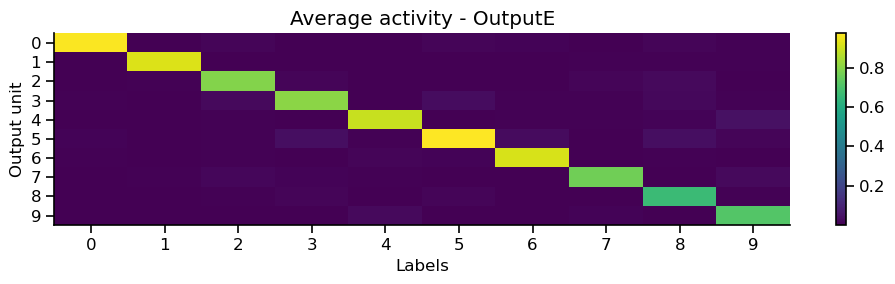

In [55]:
# Build network
config_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_van_bp_config_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257.pkl"
bp_network = build_EIANN_from_config(config_path, network_seed=66049)

data_generator.manual_seed(257)
bp_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=1,
                val_interval=(0,-1,100),
                store_history=True, 
                store_params=True,
                status_bar=True)
bp_network.save("saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_retrained.pkl")
saved_network_path = "saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_retrained.pkl"

bp_network.load(saved_network_path)
pt.plot_batch_accuracy(bp_network, test_dataloader)

In [56]:
comparison_network = build_EIANN_from_config("../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_van_bp_config_optimized.yaml", network_seed=42)
van_bpClone = ut.compute_alternate_dParam_history(train_dataloader, bp_network, constrain_params=False, save_path = "saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_bpClone.pkl")

# van_bpClone = build_EIANN_from_config("../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_van_bp_config_optimized.yaml", network_seed=42)
# van_bpClone.load("saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_bpClone.pkl")

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_bpClone.pkl


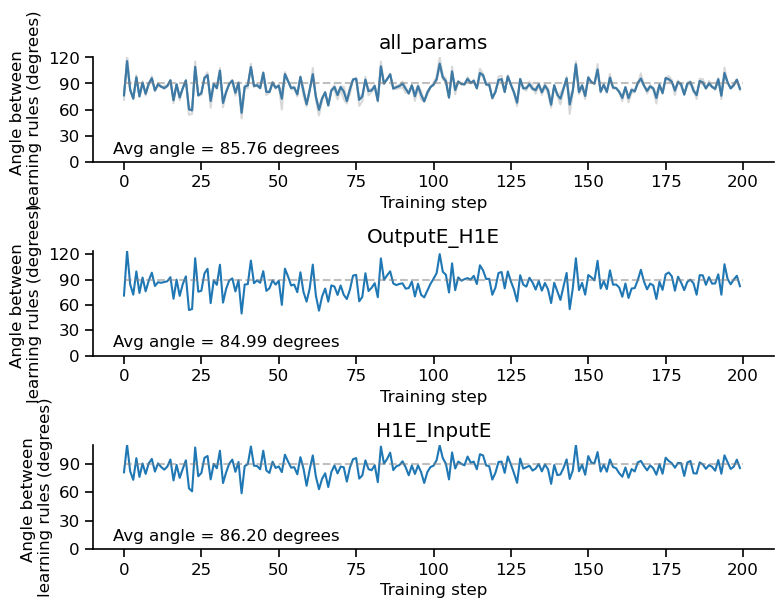

In [58]:
# Single-step stochastic backprop vs fullbatch backprop
angles = ut.compute_dW_angles(van_bpClone.predicted_dParam_history, van_bpClone.actual_dParam_history, plot=True)

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.tight_layout()


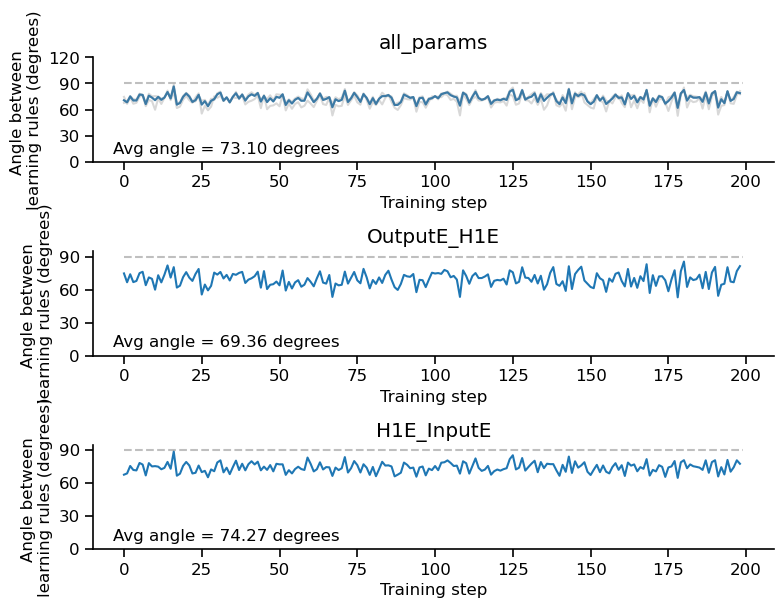

In [57]:
# Stepaveraged backprop vs fullbatch backprop
angles = ut.compute_dW_angles(van_bpClone.predicted_dParam_history, van_bpClone.actual_dParam_history_stepaveraged, plot=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_bpClone_batch100.pkl


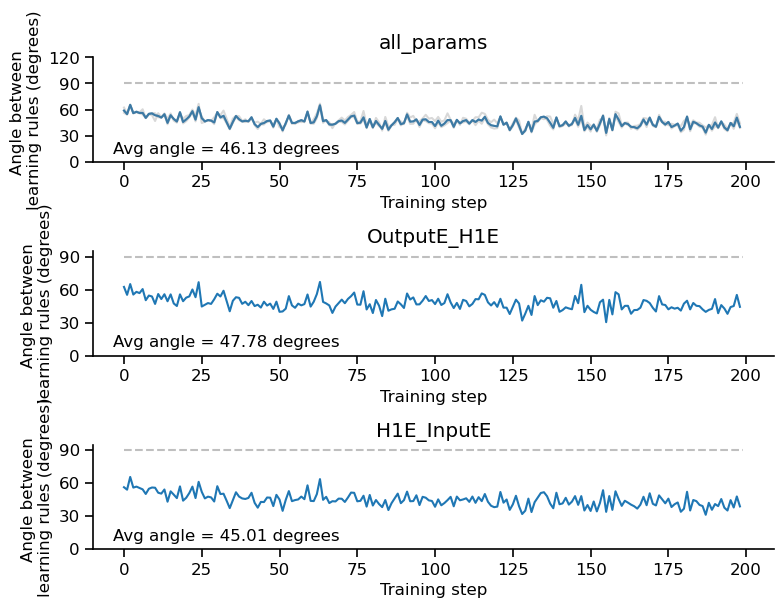

In [62]:
# Recompute dParam history with small batch size
van_bpClone2 = ut.compute_alternate_dParam_history(train_dataloader, bp_network, batch_size=100, constrain_params=False, save_path = "saved_networks/20231025_EIANN_1_hidden_mnist_van_bp_softplus_SGD_config_66049_257_bpClone_batch100.pkl")

# Stepaveraged stochastic backprop vs backprop with batch_size=100
angles = ut.compute_dW_angles(van_bpClone2.predicted_dParam_history, van_bpClone2.actual_dParam_history_stepaveraged, plot=True)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1291: RuntimeWarning: invalid value encountered in arccos
  vector_product = torch.dot(predicted_dParam, actual_dParam) / (torch.norm(predicted_dParam)*torch.norm(actual_dParam)+1e-100)


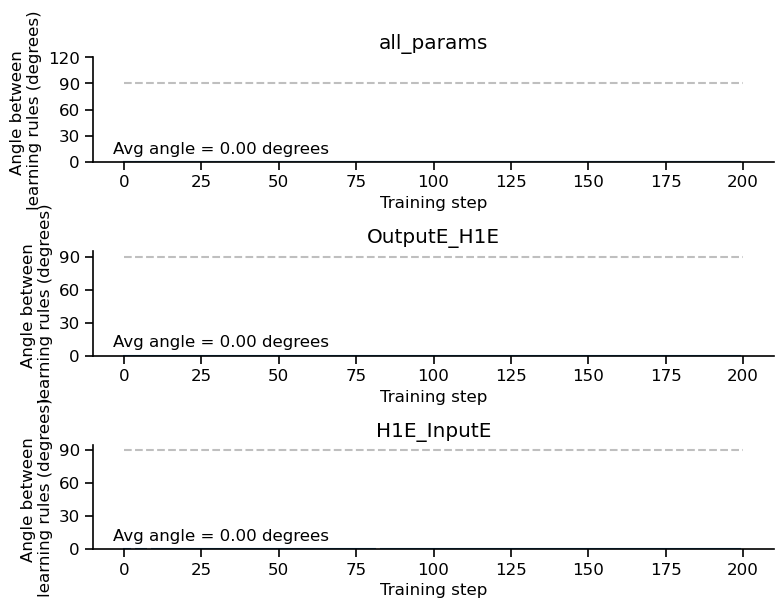

In [60]:
# Recompute dParam history with small batch size
van_bpClone3 = ut.compute_alternate_dParam_history(train_dataloader, bp_network, batch_size=1, constrain_params=False)

# Single-step stochastic backprop vs backprop with batch_size=1
angles = ut.compute_dW_angles(van_bpClone3.predicted_dParam_history, van_bpClone3.actual_dParam_history, plot=True)

## bpDale angle comparison

In [64]:
# Build network
config_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_config_G_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258.pkl"
bpDale_network = build_EIANN_from_config(config_path, network_seed=66050)

data_generator.manual_seed(258)
bpDale_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=1,
                val_interval=(0,-1,100),
                store_history=True, 
                store_params=True,
                status_bar=True)
bpDale_network.save("saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258_retrained.pkl")
saved_network_path = "saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258_retrained.pkl"

bpDale_network.load(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258_retrained.pkl
Loading model data from 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66050_258_retrained.pkl'


Batch accuracy = 95.4000015258789%


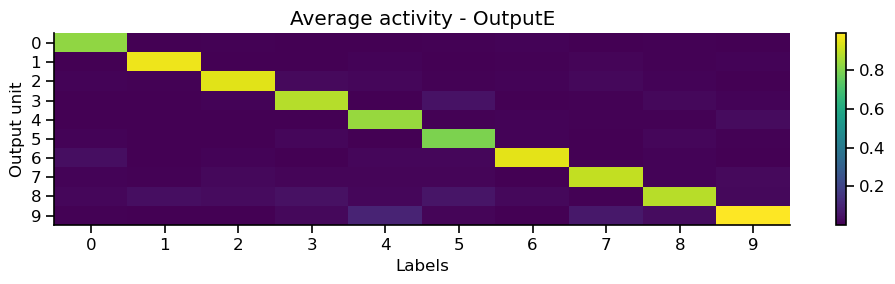

In [65]:
pt.plot_batch_accuracy(bpDale_network, test_dataloader)

In [70]:
# bpClone_network = ut.compute_alternate_dParam_history(train_dataloader, bpDale_network, constrain_params=False, save_path = 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

# bpClone_network = build_EIANN_from_config("../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_config_G_optimized.yaml", network_seed=42)
# bpClone_network.load('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

In [71]:
# # Single-step stochastic backprop vs fullbatch backprop
# angles = ut.compute_dW_angles(bpClone_network.predicted_dParam_history, bpClone_network.actual_dParam_history, plot=True)

In [72]:
# # Stepaveraged bpDale vs fullbatch backprop
# angles = ut.compute_dW_angles(bpClone_network.predicted_dParam_history, bpClone_network.actual_dParam_history_stepaveraged, plot=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone_batch100.pkl


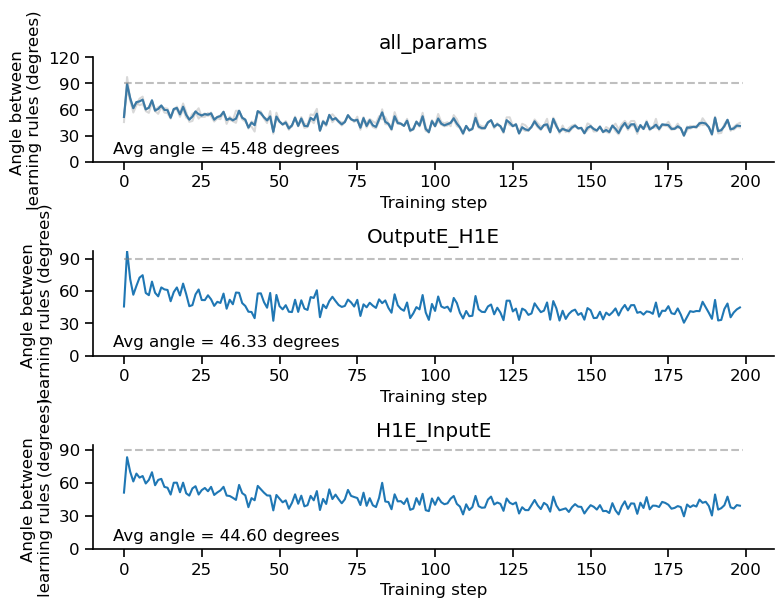

In [84]:
# Recompute dParam history with small batch size
bpClone_network2 = ut.compute_alternate_dParam_history(train_dataloader, bpDale_network, batch_size=100, constrain_params=False, save_path='saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone_batch100.pkl')

# Stepaveraged stochastic backprop vs backprop with batch_size=100
angles = ut.compute_dW_angles(bpClone_network2.predicted_dParam_history, bpClone_network2.actual_dParam_history_stepaveraged, plot=True)


  0%|          | 0/200 [00:00<?, ?it/s]

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1318: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


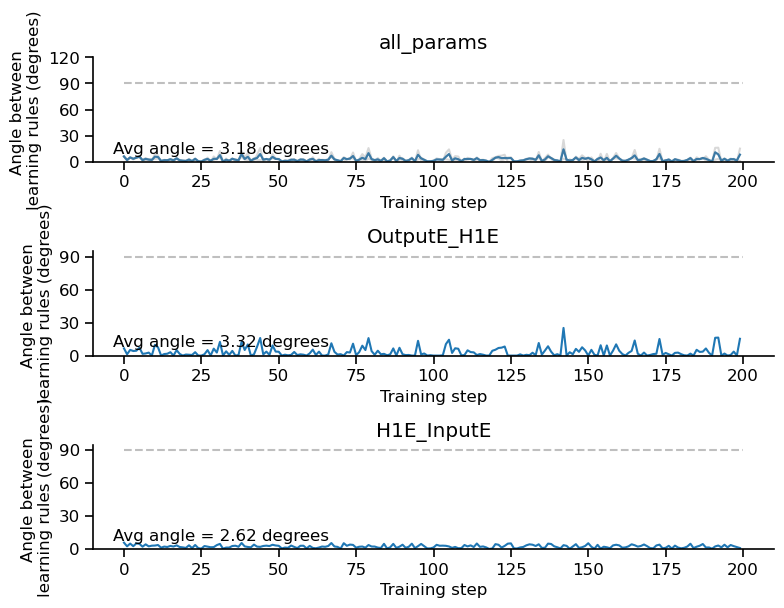

In [83]:
# Recompute dParam history with small batch size
bpClone_network3 = ut.compute_alternate_dParam_history(train_dataloader, bpDale_network, batch_size=1, constrain_params=False)

# Single-step stochastic backprop vs backprop with batch_size=1
angles = ut.compute_dW_angles(bpClone_network3.predicted_dParam_history, bpClone_network3.actual_dParam_history, plot=True)

## BTSP angle comparison

In [2]:
# Build network
config_path = "../optimize/data/mnist/20230825_EIANN_1_hidden_mnist_BTSP_config_G3_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl"
btsp_network = build_EIANN_from_config(config_path, network_seed=66049)

# data_generator.manual_seed(257)
# btsp_network.train(train_sub_dataloader, 
#                 test_dataloader, 
#                 epochs=1,
#                 val_interval=(0,-1,100),
#                 store_history=True, 
#                 store_params=True,
#                 status_bar=True)
# btsp_network.save("saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_retrained.pkl")
saved_network_path = "saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_retrained.pkl"

btsp_network.load(saved_network_path)

Loading model data from 'saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_retrained.pkl'


Batch accuracy = 83.11000061035156%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:625: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


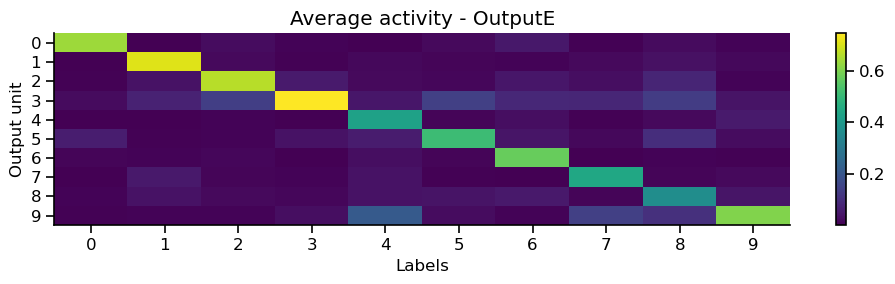

In [3]:
pt.plot_batch_accuracy(btsp_network, test_dataloader)

In [157]:
# Backprop ReLU
# btsp_bpClone = ut.compute_alternate_dParam_history(train_dataloader, btsp_network,  constrain_params=False, save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU.pkl')

btsp_bpClone = build_EIANN_from_config("../optimize/data/mnist/20230825_EIANN_1_hidden_mnist_BTSP_config_G3_optimized.yaml")
btsp_bpClone.load('saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU.pkl')

to_delete = ['module_dict.H1E_H1DendI.weight', 'module_dict.H1E_OutputE.weight']
for key in to_delete:
    del btsp_bpClone.predicted_dParam_history[key]
    del btsp_bpClone.actual_dParam_history[key]
    del btsp_bpClone.actual_dParam_history_stepaveraged[key]
ut.recompute_dParam_history_all(btsp_bpClone)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU.pkl


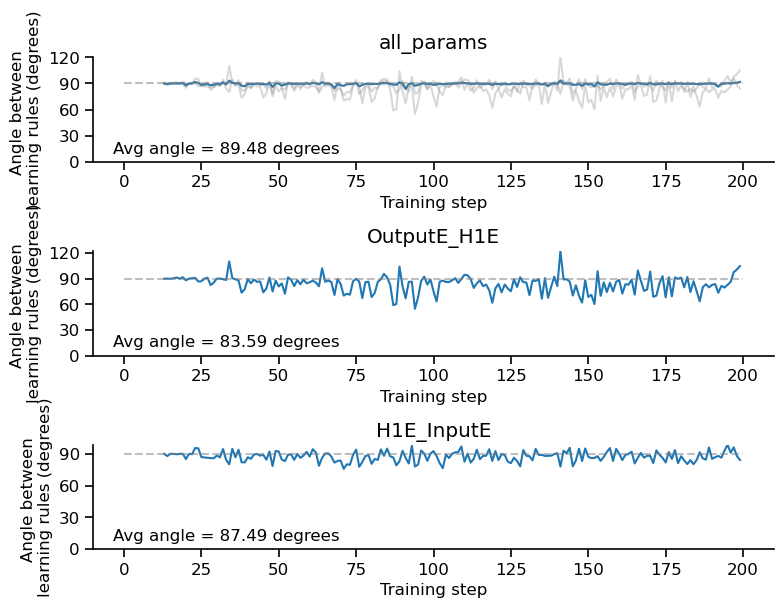

In [158]:
# Stochastic btsp vs fullbatch backprop
angles = ut.compute_dW_angles(btsp_bpClone.predicted_dParam_history, btsp_bpClone.actual_dParam_history, plot=True)

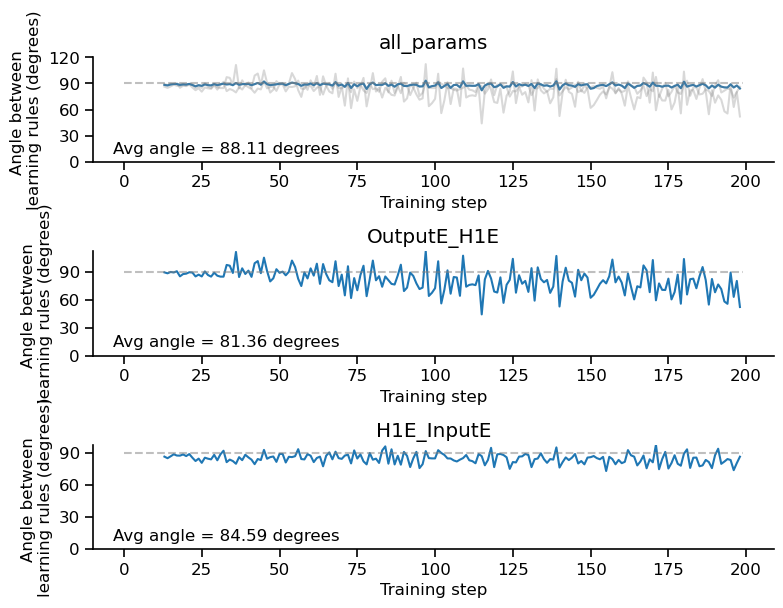

In [159]:
# Stepaveraged btsp vs fullbatch backprop
angles = ut.compute_dW_angles(btsp_bpClone.predicted_dParam_history, btsp_bpClone.actual_dParam_history_stepaveraged, plot=True)

In [5]:
# Recompute dParam history with small batch size and save to Clone network
btsp_bpClone_batch = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, batch_size=100, constrain_params=False, 
                                                        save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch100.pkl')

# btsp_bpClone_batch = build_EIANN_from_config("../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml")
# btsp_bpClone_batch.load('saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch100.pkl')

to_delete = ['module_dict.H1E_H1DendI.weight', 'module_dict.H1E_OutputE.weight']
for key in to_delete:
    del btsp_bpClone_batch.predicted_dParam_history[key]
    del btsp_bpClone_batch.actual_dParam_history[key]
    del btsp_bpClone_batch.actual_dParam_history_stepaveraged[key]
ut.recompute_dParam_history_all(btsp_bpClone_batch)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch100.pkl


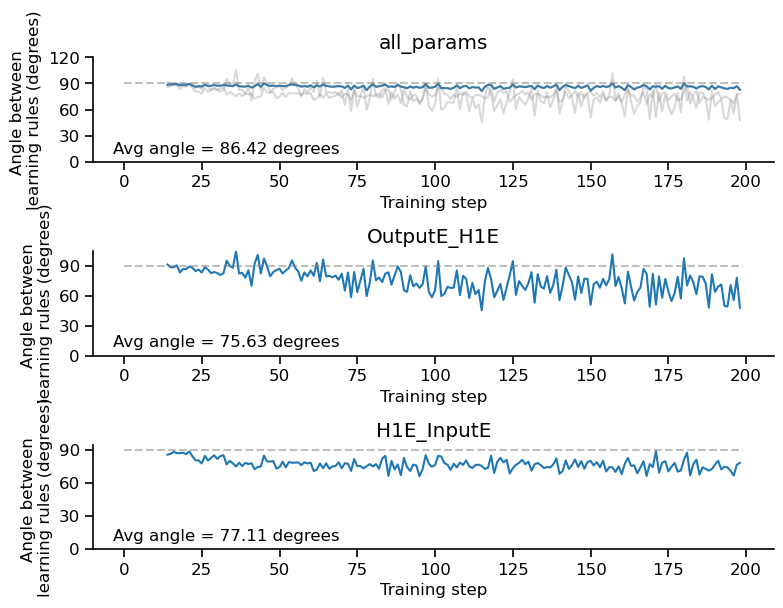

In [6]:
# Stepaveraged btsp vs backprop (batch_size=100)
angles = ut.compute_dW_angles(btsp_bpClone_batch.predicted_dParam_history, btsp_bpClone_batch.actual_dParam_history_stepaveraged, plot=True)

In [3]:
# Recompute dParam history with small batch size and save to Clone network
btsp_bpClone_batch = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, batch_size=1, constrain_params=False, 
                                                        save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch1.pkl')

# btsp_bpClone_batch = build_EIANN_from_config("../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml")
# btsp_bpClone_batch.load('saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch100.pkl')

to_delete = ['module_dict.H1E_H1DendI.weight', 'module_dict.H1E_OutputE.weight']
for key in to_delete:
    del btsp_bpClone_batch.predicted_dParam_history[key]
    del btsp_bpClone_batch.actual_dParam_history[key]
    del btsp_bpClone_batch.actual_dParam_history_stepaveraged[key]
ut.recompute_dParam_history_all(btsp_bpClone_batch)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/ag1880/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Model saved to saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpCloneReLU_batch1.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


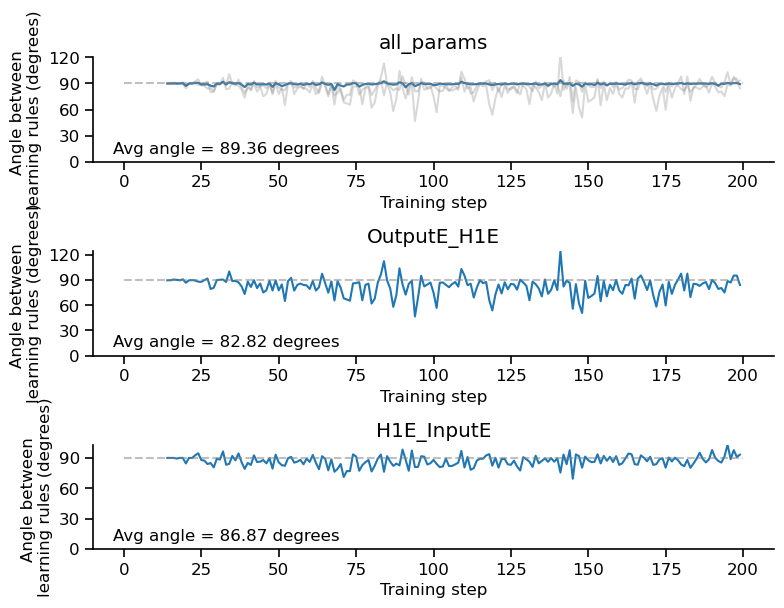

In [8]:
# Stepaveraged btsp vs backprop (batch_size=1)
angles = ut.compute_dW_angles(btsp_bpClone_batch.predicted_dParam_history, btsp_bpClone_batch.actual_dParam_history, plot=True)

## Supervised Gj-Hebb

In [164]:
# Build network
config_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257.pkl"
gj_network = build_EIANN_from_config(config_path, network_seed=66049)

data_generator.manual_seed(257)
gj_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=1,
                val_interval=(0,-1,100),
                store_history=True, 
                store_params=True,
                status_bar=True)
gj_network.save("saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl")
saved_network_path = "saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl"

ut.rename_population(gj_network, 'I', 'SomaI')
gj_network.load(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Model saved to saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl
Loading model data from 'saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl'


Batch accuracy = 64.70999908447266%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:625: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


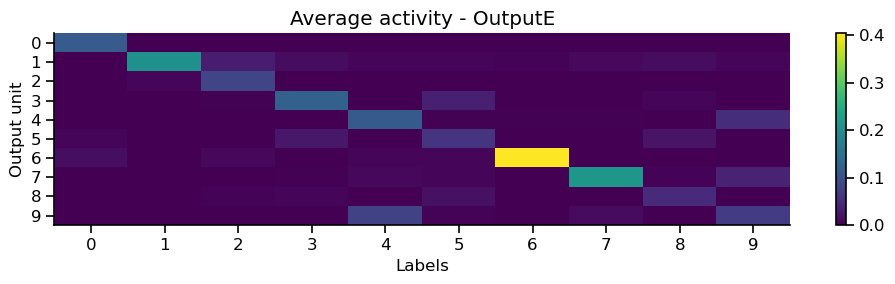

In [165]:
pt.plot_batch_accuracy(gj_network, test_dataloader)

In [171]:
hebb_bpClone = ut.compute_alternate_dParam_history(train_dataloader,gj_network, save_path='saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl')

# hebb_bpClone = build_EIANN_from_config(config_path)
# ut.rename_population(hebb_bpClone, 'I', 'SomaI')
# saved_network_path = 'saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl'
# hebb_bpClone.load(saved_network_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


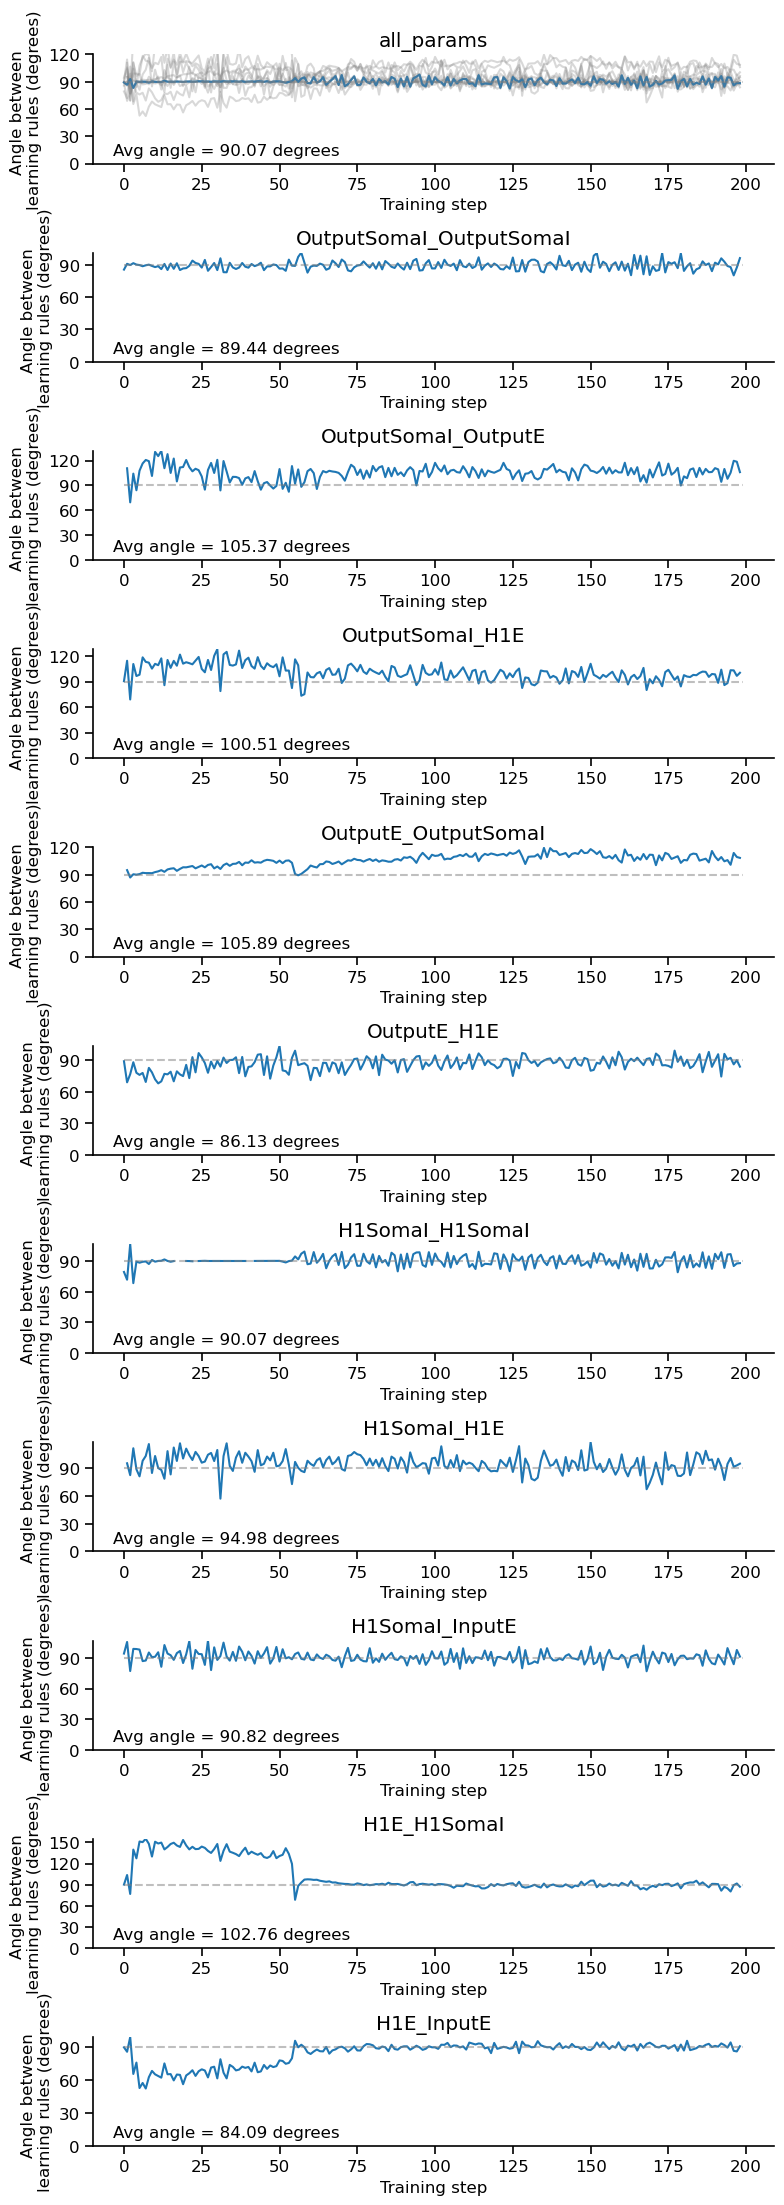

In [172]:
angles = ut.compute_dW_angles(hebb_bpClone.predicted_dParam_history, hebb_bpClone.actual_dParam_history_stepaveraged, plot=True)

In [173]:
hebb_bpClone_batch = ut.compute_alternate_dParam_history(train_dataloader,gj_network, batch_size=100,
                                                   save_path='saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_bpClone_batch100.pkl')


  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230505_EIANN_1_hidden_mnist_Supervised_Gjorgjieva_Hebb_config_F_66049_257_bpClone_batch100.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


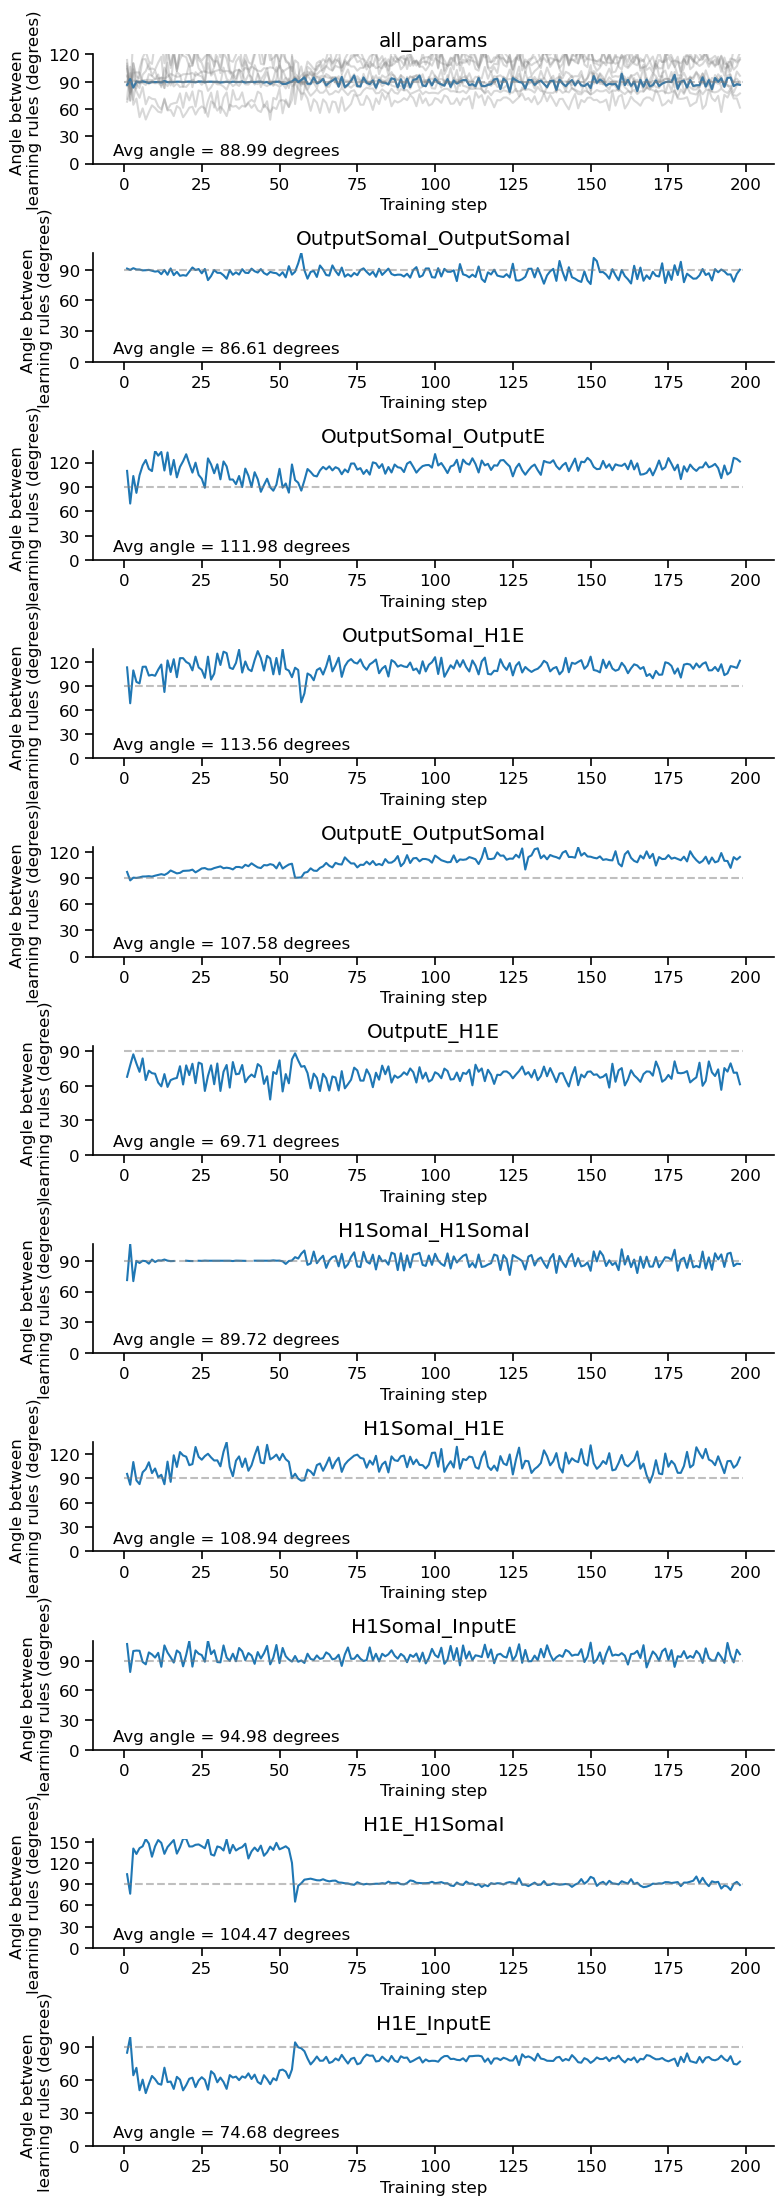

In [174]:
angles = ut.compute_dW_angles(hebb_bpClone_batch.predicted_dParam_history, hebb_bpClone_batch.actual_dParam_history_stepaveraged, plot=True)

## Supervised BCM

In [177]:
# Build network
config_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_Supervised_BCM_config_G_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257.pkl"
bcm_network = build_EIANN_from_config(config_path, network_seed=66049)

data_generator.manual_seed(257)
bcm_network.train(train_sub_dataloader, 
                test_dataloader, 
                epochs=1,
                val_interval=(0,-1,100),
                store_history=True, 
                store_params=True,
                status_bar=True)
bcm_network.save("saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_retrained.pkl")
saved_network_path = "saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_retrained.pkl"

bcm_network.load(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/20000 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_retrained.pkl
Loading model data from 'saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_retrained.pkl'


Batch accuracy = 85.76000213623047%


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/plot.py:625: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


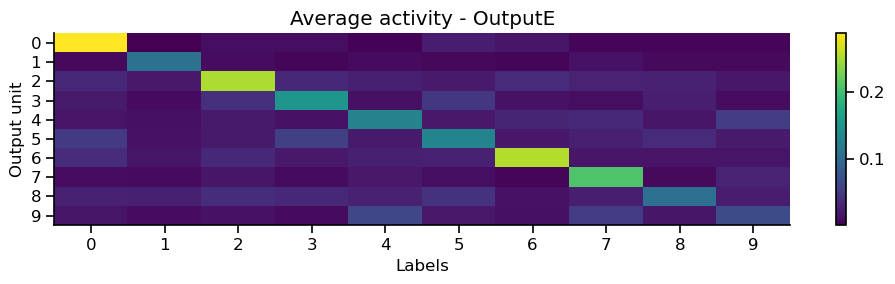

In [178]:
pt.plot_batch_accuracy(bcm_network, test_dataloader)

In [180]:
bcm_bpClone = ut.compute_alternate_dParam_history(train_dataloader,bcm_network, save_path='saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_bpClone.pkl')

# bcm_bpClone = build_EIANN_from_config(config_path, network_seed=42)
# saved_network_path = 'saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_bpClone.pkl'
# bcm_bpClone.load(saved_network_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_bpClone.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1323: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  idx, data, target = next(iter(dataloader))


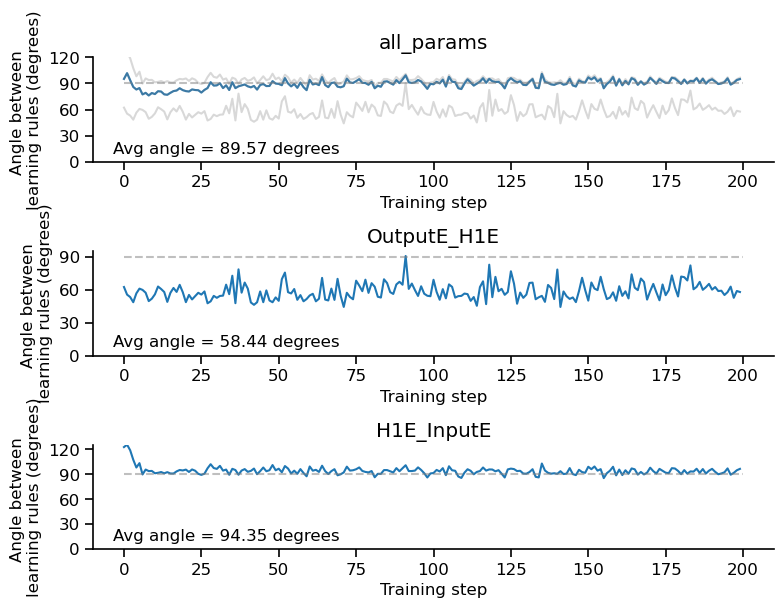

In [ ]:
angles = ut.compute_dW_angles(bcm_bpClone.predicted_dParam_history, bcm_bpClone.actual_dParam_history, plot=True)

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


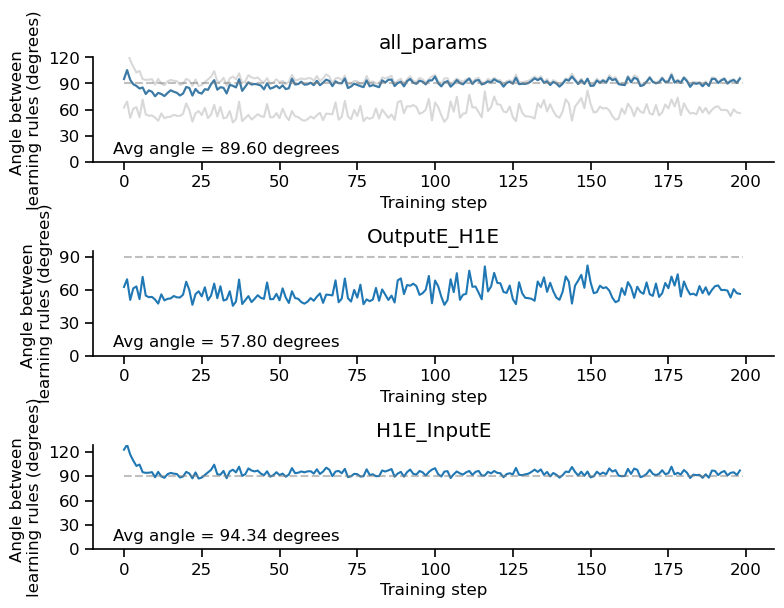

In [181]:
angles = ut.compute_dW_angles(bcm_bpClone.predicted_dParam_history, bcm_bpClone.actual_dParam_history_stepaveraged, plot=True)

In [182]:
bcm_bpClone_batch = ut.compute_alternate_dParam_history(train_dataloader,bcm_network, batch_size=100,
                                                  save_path='saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_bpClone_batch100.pkl')


  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_Supervised_BCM_config_G_66049_257_bpClone_batch100.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


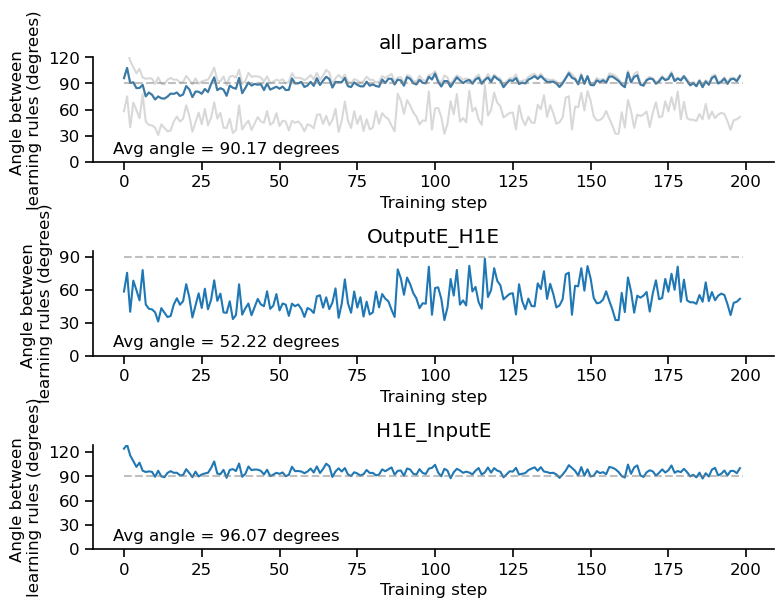

In [183]:
angles = ut.compute_dW_angles(bcm_bpClone_batch.predicted_dParam_history, bcm_bpClone_batch.actual_dParam_history_stepaveraged, plot=True)

## Unsupervised Gj-Hebb

In [184]:
# Build network
config_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257.pkl"
ugj_network = build_EIANN_from_config(config_path, network_seed=66049)

# data_generator.manual_seed(257)
# ugj_network.train(train_sub_dataloader, 
#                 test_dataloader, 
#                 epochs=1,
#                 val_interval=(0,-1,100),
#                 store_history=True, 
#                 store_params=True,
#                 status_bar=True)
# ugj_network.save("saved_networks/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl")
saved_network_path = "saved_networks/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl"

ut.rename_population(ugj_network, 'I', 'SomaI')
ugj_network.load(saved_network_path)

Loading model data from 'saved_networks/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20231025_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_retrained.pkl'


In [187]:
# ugj_bpClone = ut.compute_alternate_dParam_history(train_dataloader, ugj_network, save_path='saved_networks/20230712_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl')

ugj_bpClone = build_EIANN_from_config(config_path)
saved_network_path = 'saved_networks/20230712_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl'
ugj_bpClone.load(saved_network_path)

Loading model data from 'saved_networks/20230712_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230712_EIANN_1_hidden_mnist_Gjorgjieva_Hebb_config_F_66049_257_bpClone.pkl'


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


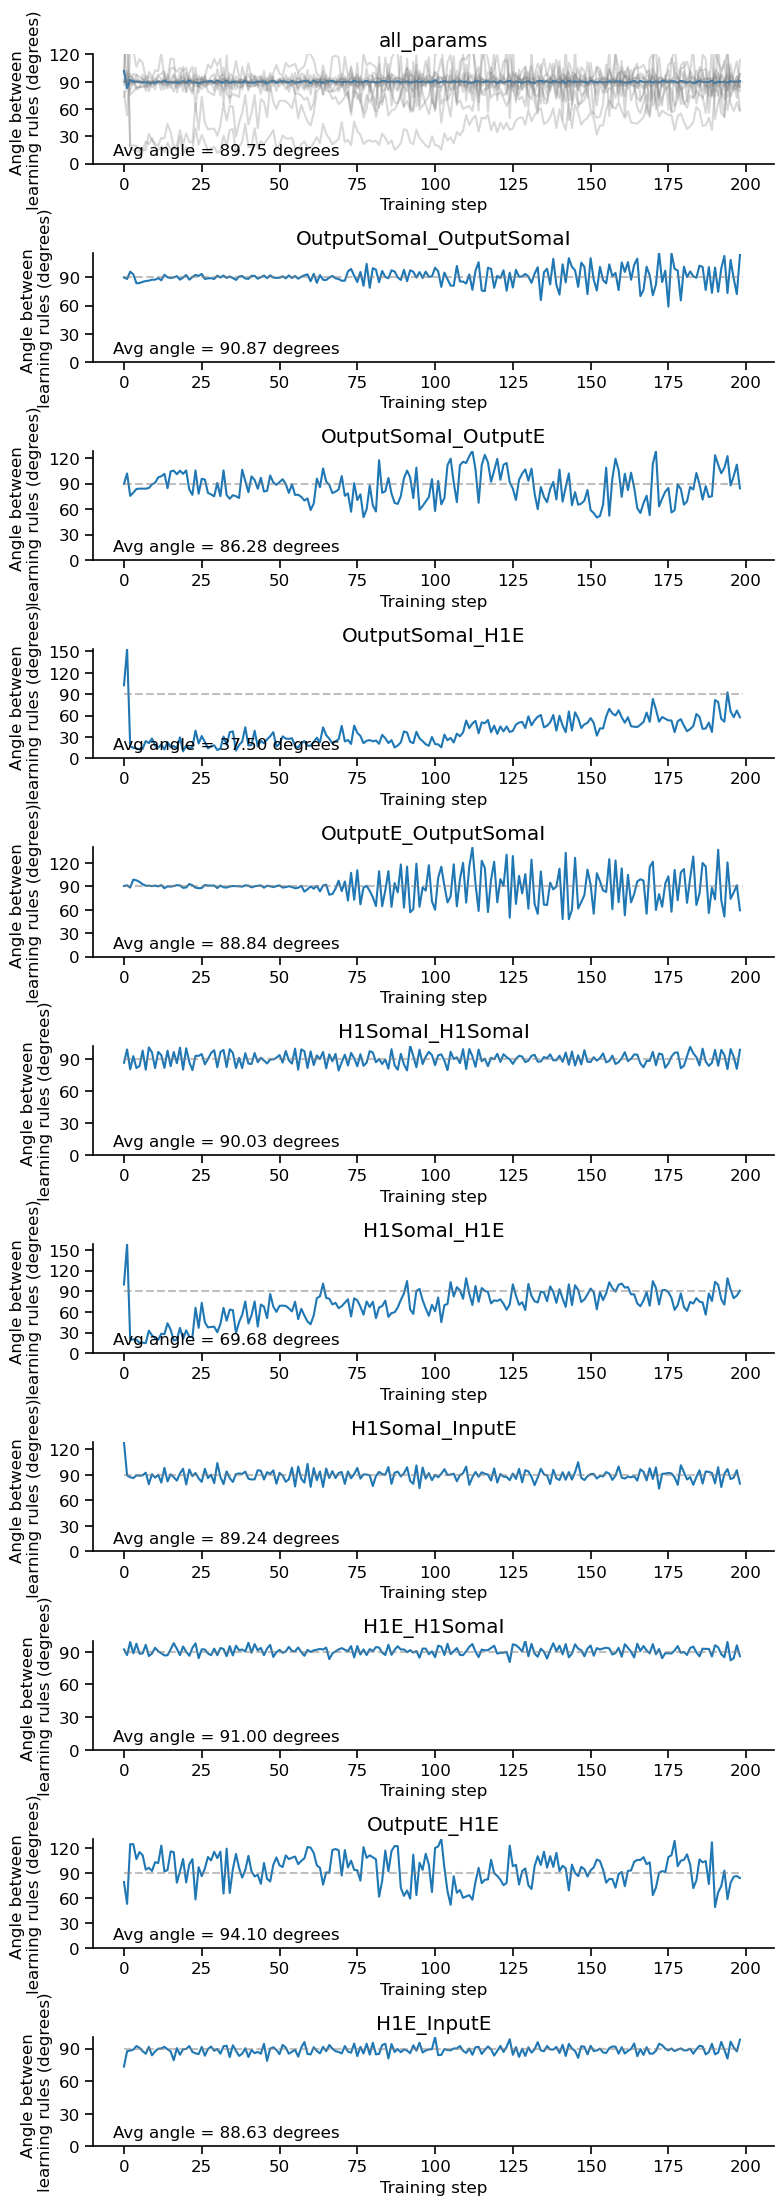

In [189]:
angles = ut.compute_dW_angles(ugj_bpClone.predicted_dParam_history, ugj_bpClone.actual_dParam_history_stepaveraged, plot=True)

  0%|          | 0/200 [00:00<?, ?it/s]

/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1317: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


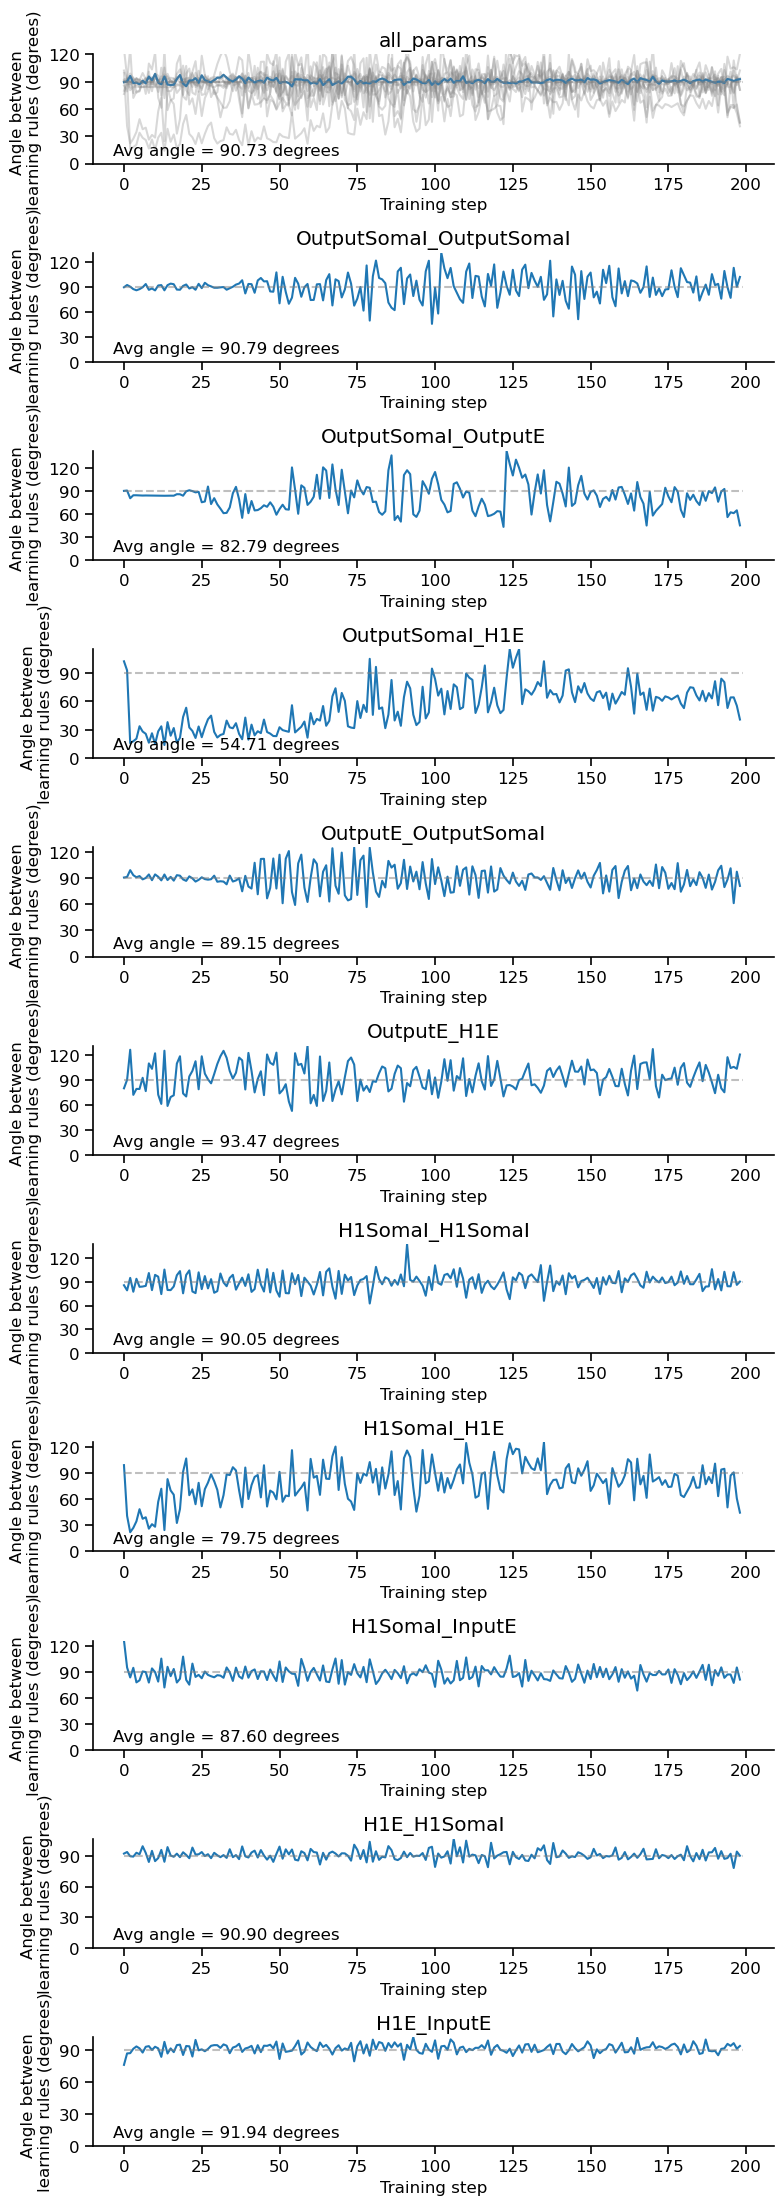

In [191]:
ugj_bpClone_batch = ut.compute_alternate_dParam_history(train_dataloader, ugj_network, batch_size=100)

angles = ut.compute_dW_angles(ugj_bpClone_batch.predicted_dParam_history, ugj_bpClone_batch.actual_dParam_history_stepaveraged, plot=True)

## Unsupervised BCM

In [9]:
# Build network
config_path = "../optimize/data/mnist/20231025_EIANN_1_hidden_mnist_BCM_config_G_optimized.yaml"
saved_network_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257.pkl"
ubcm_network = build_EIANN_from_config(config_path, network_seed=66049)

# data_generator.manual_seed(257)
# ubcm_network.train(train_sub_dataloader, 
#                 test_dataloader, 
#                 epochs=1,
#                 val_interval=(0,-1,100),
#                 store_history=True, 
#                 store_params=True,
#                 status_bar=True)
# ubcm_network.save("saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_retrained.pkl")
saved_network_path = "saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_retrained.pkl"

ubcm_network.load(saved_network_path)

Loading model data from 'saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_retrained.pkl'...
Loading parameters into the network...
Model successfully loaded from 'saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_retrained.pkl'


In [10]:
ubcm_bpClone = ut.compute_alternate_dParam_history(train_dataloader, ubcm_network, save_path='saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_bpClone.pkl')

# ubcm_bpClone = build_EIANN_from_config(config_path, network_seed=42)
# saved_network_path = 'saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_bpClone.pkl'
# ubcm_bpClone.load(saved_network_path)

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_BCM_config_G_66049_257_bpClone.pkl
